In [1]:
from scipy import io
import GPy
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb

In [2]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)

In [3]:
def build_XY(input_list,output_list=None):
    num_outputs = len(input_list)
    Y = np.vstack(output_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,Y,I

In [4]:
mat_file1 = io.loadmat('2014_Dataset7.mat')
t = mat_file1['t']
p1 = mat_file1['p1']
p2 = mat_file1['p2']

In [7]:
for i in range(len(p2)):
    if p2[i]<100:
        p2[i] = p2[i]*100

 C:\Users\Woojin Cho\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning:invalid value encountered in less


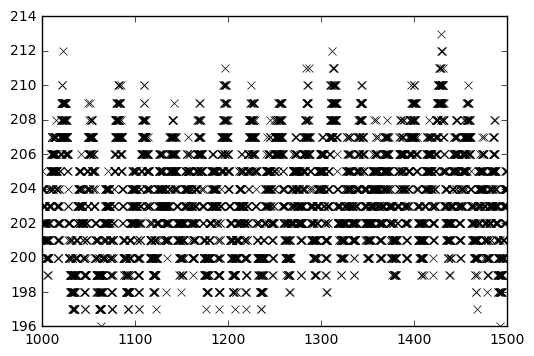

In [12]:
x = np.arange(0,len(p2)/10,0.1)[:,None]
plt.plot(x[10000:15000],p2[10000:15000],'kx')
plt.show()

# Training

In [13]:
K1 = GPy.kern.RBF(1)
K2 = GPy.kern.Exponential(1)
K3 = GPy.kern.Matern32(1)
K4 = GPy.kern.Matern52(1)
K5 = GPy.kern.PeriodicExponential(1)
K6 = GPy.kern.PeriodicMatern32(1)
K7 = GPy.kern.PeriodicMatern52(1)
K8 = GPy.kern.RBF(1)

In [14]:
i = range(10000, 15000)
j = range(10000, 15000)

In [15]:
lcm = GPy.util.multioutput.LCM(input_dim=1,num_outputs=2,kernels_list=[K1,K7])
mul = GPy.models.GPCoregionalizedRegression([x[i],x[j]],[p1[i],p2[j]],kernel=lcm)
# mul1['.*periodic_Matern32.period'].constrain_fixed(28.8)
mul.optimize()
import pickle
f = open('d:/hyperparameter7','wb')
pickle.dump(mul,f)
f.close()

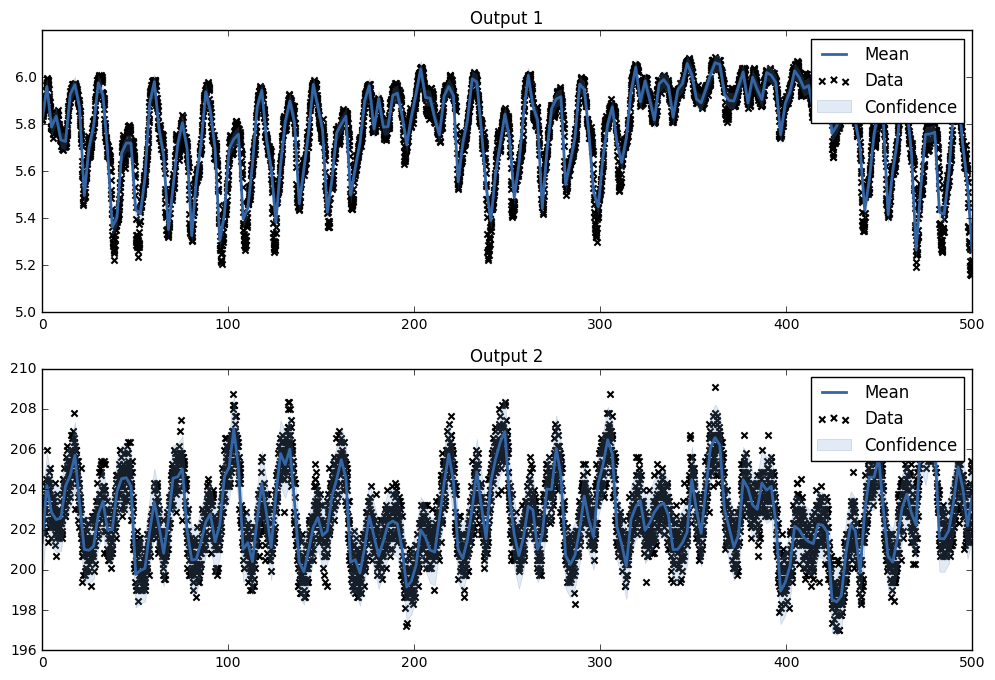

In [9]:
plot_2outputs(mul, xlim=(x[0],x[5000]),x_1=x[i],x_2=x[j])
plt.show()

In [12]:
mul

gp.,value,constraints,priors
sum.ICM0.rbf.variance,18.8496708857,+ve,
sum.ICM0.rbf.lengthscale,1.73690819959,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.periodic_Matern52.variance,0.833650651036,+ve,
sum.ICM1.periodic_Matern52.lengthscale,1.18805153455,+ve,
sum.ICM1.periodic_Matern52.period,5.99948056739,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.000269188706549,+ve,


In [18]:
import pickle
f = open('hyperparameter','wb')
pickle.dump(mul,f)
f.close()

# Test Set

In [20]:
s = 0
l = 400
t = 10
it = range(s,s+l)
jt = range(s,s+l-t)
test = range(s+l-t,s+l)
kernel = mul.kern.copy()

In [27]:
mul2 = GPy.models.GPCoregionalizedRegression([x[it],x[jt]],[p1[it],p2[jt]],kernel = kernel)

In [32]:
mul2

gp.,value,constraints,priors
sum.ICM0.rbf.variance,18.8496708857,fixed +ve,
sum.ICM0.rbf.lengthscale,1.73690819959,fixed +ve,
sum.ICM0.B.W,"(2, 1)",fixed,
sum.ICM0.B.kappa,"(2,)",fixed +ve,
sum.ICM1.periodic_Matern52.variance,0.833650651036,fixed +ve,
sum.ICM1.periodic_Matern52.lengthscale,1.18805153455,fixed +ve,
sum.ICM1.periodic_Matern52.period,5.99948056739,fixed +ve,
sum.ICM1.B.W,"(2, 1)",fixed,
sum.ICM1.B.kappa,"(2,)",fixed +ve,
mixed_noise.Gaussian_noise_0.variance,0.000269188706549,fixed +ve,


In [31]:
# mul2['.*rbf.variance'].constrain_fixed(mul.sum.ICM0.rbf.variance)
# mul2['.*rbf.lengthscale'].constrain_fixed(mul.sum.ICM0.rbf.lengthscale)
# mul2['.*periodic_Matern52.variance'].constrain_fixed(mul.sum.ICM1.periodic_Matern52.variance)
# mul2['.*periodic_Matern52.lengthscale'].constrain_fixed(mul.sum.ICM1.periodic_Matern52.lengthscale)
# mul2['.*periodic_Matern52.period'].constrain_fixed(mul.sum.ICM1.periodic_Matern52.period)
mul2['.*Gaussian_noise_0.variance'].constrain_fixed(mul.mixed_noise.Gaussian_noise_0.variance)
mul2['.*Gaussian_noise_1.variance'].constrain_fixed(mul.mixed_noise.Gaussian_noise_1.variance)
# mul2['.*ICM0.B.W'].constrain_fixed(mul.sum.ICM0.B.W)
# mul2['.*ICM1.B.W'].constrain_fixed(mul.sum.ICM1.B.W)
# mul2['.*ICM0.B.kappa'].constrain_fixed(mul.sum.ICM0.B.kappa)
# mul2['.*ICM1.B.kappa'].constrain_fixed(mul.sum.ICM1.B.kappa)

array([0])

In [26]:
mul2

gp.,value,constraints,priors
sum.ICM0.rbf.variance,18.8496708857,fixed +ve,
sum.ICM0.rbf.lengthscale,1.73690819959,fixed +ve,
sum.ICM0.B.W,"(2, 1)",fixed,
sum.ICM0.B.kappa,"(2,)",fixed +ve,
sum.ICM1.periodic_Matern52.variance,0.833650651036,fixed +ve,
sum.ICM1.periodic_Matern52.lengthscale,1.18805153455,fixed +ve,
sum.ICM1.periodic_Matern52.period,5.99948056739,fixed +ve,
sum.ICM1.B.W,"(2, 1)",fixed,
sum.ICM1.B.kappa,"(2,)",fixed +ve,
mixed_noise.Gaussian_noise_0.variance,0.000269188706549,fixed +ve,


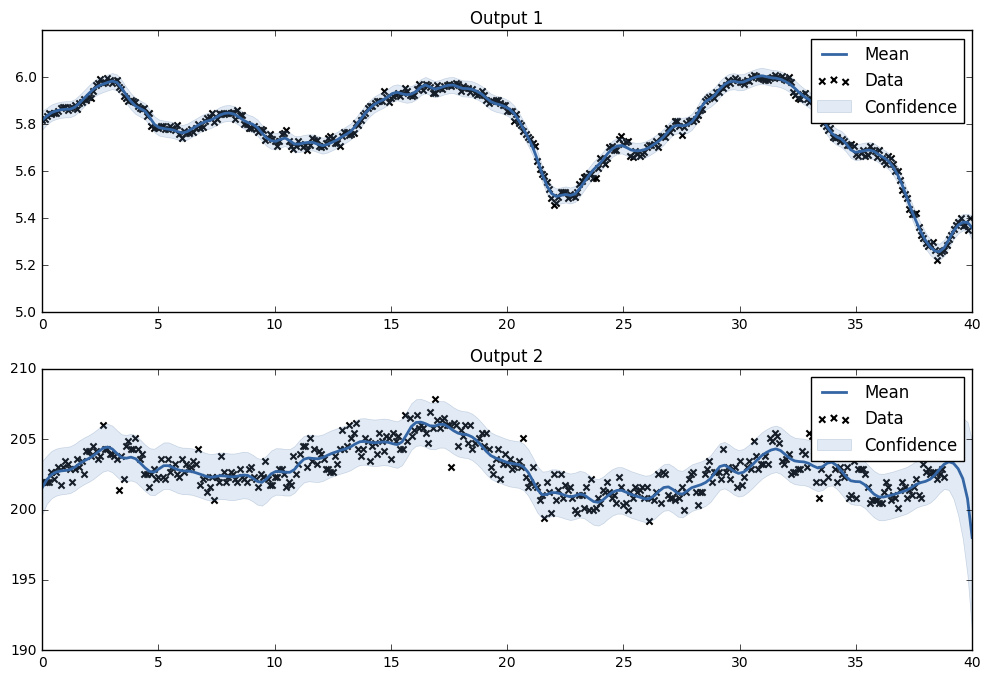

In [33]:
plot_2outputs(mul2, xlim=(x[s],x[s+l]),x_1=x[it],x_2=x[jt])
plt.show()

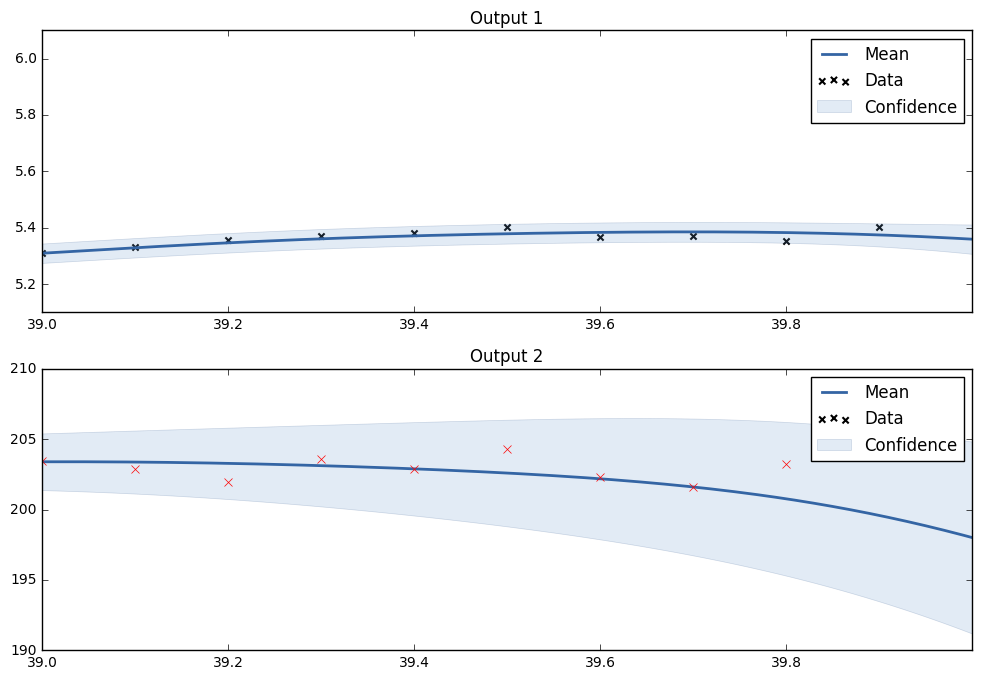

In [34]:
plot_2outputs(mul2, xlim=(x[s+l-1*t],x[s+l]),x_1=x[it],x_2=x[jt])
plt.plot(x[test],p2[test],'kx',color='red')
plt.show()

# Anomaly Score

In [90]:
X,Y,I = build_XY([x[it],x[it]],[p1[it],p2[it]])
mu,var = mul2.predict(X,Y_metadata=I,kern=mul2.kern,likelihood=mul2.likelihood)
mu2 = mu[int(len(mu)/2):len(mu)]
var2 = var[int(len(mu)/2):len(mu)]

In [109]:
score = 0.5*np.log(var2[test]*np.pi*2) + (p2[test]-mu2[test])**2/(2*var2[test])
np.average(score)

2.0743724729091233

# Sequential

In [40]:
def hyper_fix_score(kernel,mul2,s,l,t):
    it = range(s,s+l)
    jt = range(s,s+l-t)
    test = range(l-t,l)    
    mul2 = GPy.models.GPCoregionalizedRegression([x[it],x[jt]],[p1[it],p2[jt]],kernel = kernel)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(mul.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(mul.mixed_noise.Gaussian_noise_1.variance)
    X,Y,I = build_XY([x[it],x[it]],[p1[it],p2[it]])
    mu,var = mul2.predict(X,Y_metadata=I,kern=mul2.kern,likelihood=mul2.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    score = 0.5*np.log(var2[test]*np.pi*2) + (p2[test]-mu2[test])**2/(2*var2[test])
    a = np.average(score)
    return a

In [42]:
s = 0
l = 400
t = 10
score_list = []
kern = mul.kern.copy()
for i in range(len(x)):
    a = hyper_fix_score(kern,mul2,s,l,t)
    score_list.append(a)
    s += 1

IndexError: index 17250 is out of bounds for axis 0 with size 17250

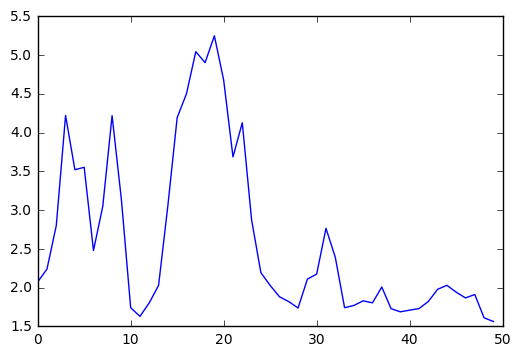

In [112]:
plt.figure(figsize=(20,10))
plt.plot(score_list)
plt.show()

In [15]:
if 0.1:
    print(1)

1
